In [52]:
import sys
sys.path.append('../')
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from notebook_setup import device, smooth_graph, create_new_set_of_models, train_models_and_get_histories, update_dict
from ocd.models.oslow import OSlow
from ocd.data.synthetic.graph_generator import GraphGenerator
from ocd.data.synthetic.utils import RandomGenerator
from ocd.data.synthetic.parametric import AffineParametericDataset
from ocd.data.synthetic.nonparametric import AffineNonParametericDataset
from ocd.models.normalization import ActNorm
from ocd.training.trainer import Trainer
from ocd.config import GumbelTopKConfig
from tqdm import tqdm
import numpy as np

%load_ext autoreload
%autoreload 2
print(device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [55]:
num_samples = 2000
batch_size = 128
perm_n_samples = 128
epochs = 500
flow_lr = 0.005
perm_lr= 0.005
flow_freq = 4
perm_freq = 1

In [56]:

graph_generator = GraphGenerator(
    num_nodes=3,
    seed=0,
    graph_type="full",
    enforce_ordering=[1, 0, 2],
)
graph = graph_generator.generate_dag()

# These generators are also needed to generate the data
gaussian_noise_generator = RandomGenerator('normal', seed=10, loc=0, scale=1)
link_generator = RandomGenerator('uniform', seed=110, low=1, high=1)

# parameteric with sin(x) + x non-linearity and softplus
dset_sinusoidal = AffineParametericDataset(
    num_samples=num_samples,
    graph=graph,
    noise_generator=gaussian_noise_generator,
    link_generator=link_generator,
    link="sinusoid",
    perform_normalization=False,
)

dataset = TensorDataset(torch.tensor(dset_sinusoidal.samples.values).float())
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [57]:
model  = OSlow(in_features=3,
               layers=[20, 20],
               dropout=None,
               residual=False,
               activation=torch.nn.LeakyReLU(),
               additive=False,
               num_transforms=1,
               normalization=ActNorm,
               base_distribution=torch.distributions.Normal(loc=0, scale=1),
               ordering=None)

flow_optimizer = lambda params: torch.optim.Adam(params, lr=flow_lr)
perm_optimizer = lambda params: torch.optim.Adam(params, lr=perm_lr)

permutation_learning_config = GumbelTopKConfig(num_samples=perm_n_samples,
                                               sampling_method="unique")
trainer = Trainer(model=model,
                  dataloader=dataloader,
                  flow_optimizer=flow_optimizer,
                  permutation_optimizer=perm_optimizer,
                  flow_frequency=flow_freq,
                  permutation_frequency=perm_freq,
                  max_epochs=epochs,
                  flow_lr_scheduler=torch.optim.lr_scheduler.ConstantLR,
                  permutation_lr_scheduler=torch.optim.lr_scheduler.ConstantLR,
                  permutation_learning_config=permutation_learning_config,
                  device=device)

In [58]:
histories = trainer.train()

training the permutation:   0%|          | 0/101 [00:00<?, ?it/s]

training the permutation: 100%|██████████| 101/101 [03:04<00:00,  1.83s/it, permutation loss=7]


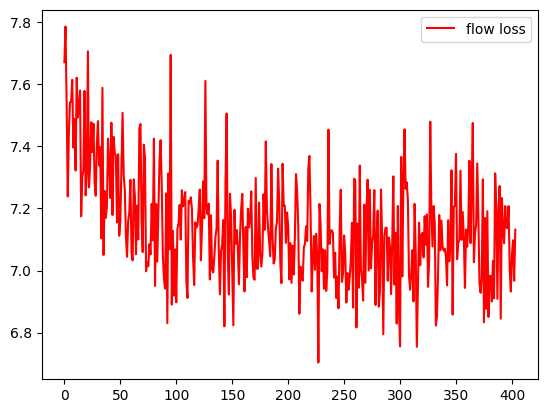

In [68]:
plt.plot(histories['flow_loss'], label='flow loss', color='red')
plt.legend()
plt.show()

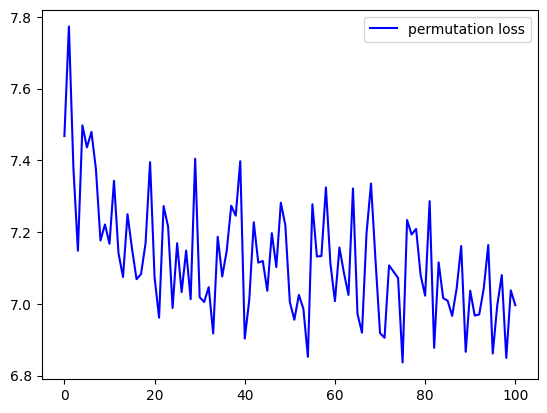

In [69]:
plt.plot(histories['permutation_loss'], label='permutation loss', color='blue')
plt.legend()
plt.show()

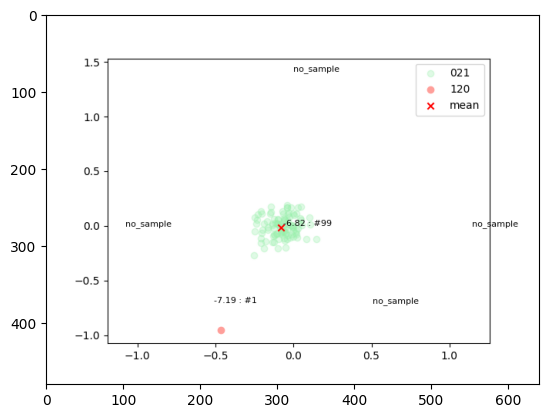

In [60]:
from ocd.visualization.birkhoff import visualize_birkhoff_polytope
img = visualize_birkhoff_polytope(
    permutation_model=trainer.permutation_learning_module,
    num_samples=100,
    data=torch.from_numpy(dset_sinusoidal.samples.values[:100]),
    flow_model=model,
    device=device,
)
plt.imshow(img)
plt.show()